In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Turn americangut into a binary classification problem


In [3]:
import anndata
import numpy as np


In [4]:
adata = anndata.read_h5ad("data/americangut_embeddings.h5ad")


In [5]:
def report(column, normalize=False):
    """Report on column values. Call this for manual inspection"""
    print(adata.obs[column].str.lower().value_counts(normalize=normalize))


report("ibd")


ibd
i do not have this condition                                         26122
nan                                                                   5137
diagnosed by a medical professional (doctor, physician assistant)     1089
self-diagnosed                                                         219
diagnosed by an alternative medicine practitioner                       37
not provided                                                             3
unspecified                                                              1
Name: count, dtype: int64


In [6]:
# Use this to build up a master list

for col in adata.obs.columns[50:60]:
    print(adata.obs.dtypes[col])
    if adata.obs.dtypes[col] == "category":
        report(col)

neg_master = ["no", "false", "i do not have this condition", "never"]

pos_master = [
    "yes",
    "true",
    "diagnosed by a medical professional (doctor, physician assistant)",
    "self-diagnosed",
    "diagnosed by an alternative medicine practitioner",
    "rarely (less than once/week)",
    "rarely (a few times/month)",
    "occasionally (1-2 times/week)",
    "regularly (3-5 times/week)",
    "daily",
]

nan_master = ["nan", "not provided", "not sure", "not collected", "unspecified"]


category
cancer_treatment
nan                  31048
surgery only           847
chemotherapy           260
not provided           188
radiation therapy      173
no treatment            87
unspecified              5
Name: count, dtype: int64
category
cardiovascular_disease
i do not have this condition                                         22371
nan                                                                   9158
diagnosed by a medical professional (doctor, physician assistant)     1041
self-diagnosed                                                          30
diagnosed by an alternative medicine practitioner                        6
not provided                                                             2
Name: count, dtype: int64
category
cat
no              21186
yes              7243
nan              4171
false               6
not provided        1
true                1
Name: count, dtype: int64
category
cdiff
i do not have this condition                                     

In [7]:
def classify(
    column,
    pos_vals=pos_master,
    neg_vals=neg_master,
    nan_vals=nan_master,
    data=adata.X.toarray(),
    balance=False,
    seed=None,
):
    vals = adata.obs[column].str.lower()
    nan_vals = vals.isna() | vals.isin(nan_vals)
    pos_vals = vals.isin(pos_vals)
    neg_vals = vals.isin(neg_vals)
    assert not (pos_vals & neg_vals).any()
    try:
        assert (pos_vals | neg_vals | nan_vals).all()
    except AssertionError:
        print(column)
        print(vals[~(pos_vals | neg_vals | nan_vals)])

    X = np.array(data)[~nan_vals]
    y = np.array(pos_vals)[~nan_vals]

    n_pos = y.sum()
    n_neg = (~y).sum()

    if balance:
        if seed is not None:
            np.random.seed(seed)
        # Balance the classes
        if n_pos > n_neg:
            drop = np.random.choice(
                np.where(y)[0], n_pos - n_neg, replace=False
            )
        elif n_neg > n_pos:
            drop = np.random.choice(
                np.where(~y)[0], n_neg - n_pos, replace=False
            )
        X = np.delete(X, drop, axis=0)
        y = np.delete(y, drop, axis=0)

    return X, y


In [8]:
X_ibd, y_ibd = classify(column="ibd", balance=True)


In [9]:
# Basic experiment: XGBoost in different embeddings
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import pandas as pd

X_np = adata.X.toarray()

NDIM = 64

results = []
for column in ["ibd", "asd", "vivid_dreams"]:
    for embedding in [
        f"hyp_mix_{NDIM}",
        f"poi_mix_{NDIM}",
        f"euc_mix_{NDIM}",
        f"pca_{NDIM}",
    ]:
        X, y = classify(
            column=column, data=adata.obsm[embedding], balance=True, seed=42
        )
        xgb = XGBClassifier()
        score = cross_val_score(xgb, X, y, cv=5)
        print(
            f"{column} ({len(X)})\t{embedding}\t{score.mean():.4f} ± {score.std():.4f}"
        )
        results.append(
            {
                "column": column,
                "embedding": embedding,
                "score": score.mean(),
                "score_std": score.std(),
            }
        )
        print()

results = pd.DataFrame(results)


KeyboardInterrupt: 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'ibd hyp_mix_64'),
  Text(1, 0, 'ibd poi_mix_64'),
  Text(2, 0, 'ibd euc_mix_64'),
  Text(3, 0, 'ibd pca_64'),
  Text(4, 0, 'asd hyp_mix_64'),
  Text(5, 0, 'asd poi_mix_64'),
  Text(6, 0, 'asd euc_mix_64'),
  Text(7, 0, 'asd pca_64'),
  Text(8, 0, 'vivid_dreams hyp_mix_64'),
  Text(9, 0, 'vivid_dreams poi_mix_64'),
  Text(10, 0, 'vivid_dreams euc_mix_64'),
  Text(11, 0, 'vivid_dreams pca_64')])

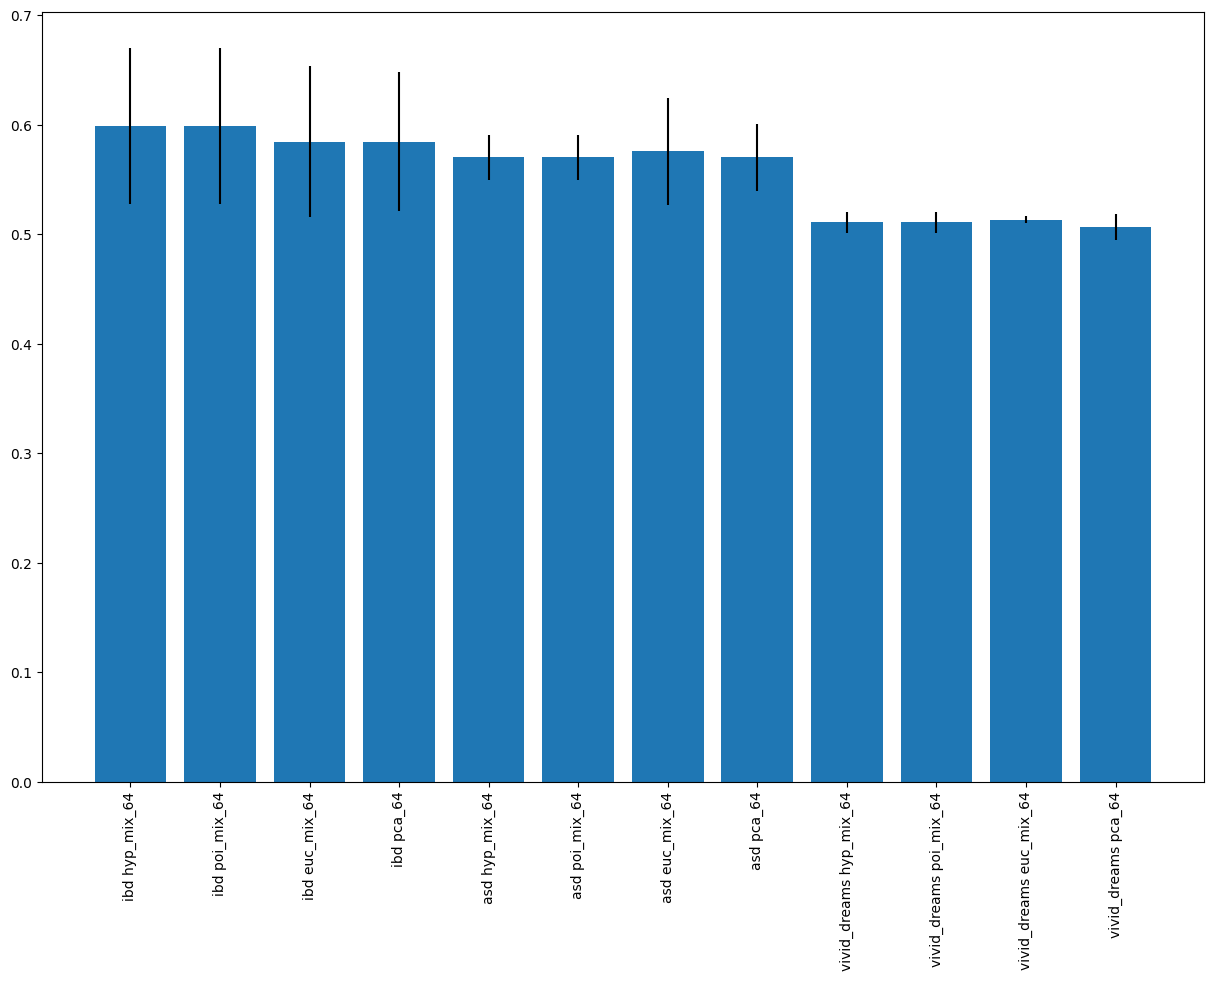

In [ ]:
# Make a bar plot

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
plt.bar(
    results["column"] + " " + results["embedding"],
    results["score"],
    yerr=results["score_std"],
)
plt.xticks(rotation=90)


In [10]:
# Drop boring columns
for col in reversed(adata.obs.columns):
    vals = adata.obs[col]
    if vals.dtype.name == "category":
        vals = vals.str.lower()
        nan_indicator = vals.isin(nan_master)
        n_nans = nan_indicator.sum()
        vals_filtered = vals[~nan_indicator]
    else:
        nan_indicator = np.isnan(vals)
        n_nans = nan_indicator.sum()
    if n_nans > 20000:
        print(f"Dropping {col} with {n_nans} nan values")
        adata.obs.drop(columns=col, inplace=True)

    elif vals[~nan_indicator].nunique() == 1:
        print(f"Dropping {col} with only one unique value")
        adata.obs.drop(columns=col, inplace=True)


Dropping weight_units with 32608 nan values
Dropping weight_kg with 32608 nan values
Dropping weight_cat with 32589 nan values
Dropping weekend_wake_time with 32608 nan values
Dropping weekend_sleep_time with 32608 nan values
Dropping weekday_wake_time with 32608 nan values
Dropping weekday_sleep_time with 32608 nan values
Dropping vioscreen_zinc with 32608 nan values
Dropping vioscreen_xylitol with 32608 nan values
Dropping vioscreen_whole_grain_servings with 32608 nan values
Dropping vioscreen_wgrain with 32608 nan values
Dropping vioscreen_weight with 32608 nan values
Dropping vioscreen_water with 32608 nan values
Dropping vioscreen_vitk with 32608 nan values
Dropping vioscreen_vite_iu with 32608 nan values
Dropping vioscreen_vitd_iu with 32608 nan values
Dropping vioscreen_vitd3 with 32608 nan values
Dropping vioscreen_vitd2 with 32608 nan values
Dropping vioscreen_vitd with 32608 nan values
Dropping vioscreen_vitc with 32608 nan values
Dropping vioscreen_vitb6 with 32608 nan value

In [27]:
import sys

sys.path.append("/home/phil/hdt")

from src.tree import HyperbolicDecisionTreeClassifier
from src.forest import HyperbolicRandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [47]:
# %%prun

from sklearn.base import BaseEstimator
from tqdm.notebook import tqdm

results = pd.DataFrame(
    columns=[
        "column",
        "embedding",
        "dt_score",
        "dt_score_std",
        "rf_score",
        "rf_score_std",
        "hdt_score",
        "hdt_score_std",
        "hrf_score",
        "hrf_score_std",
    ]
)
for col in tqdm(adata.obs.columns):
    print(col)
    if adata.obs.dtypes[col].name == "category":
        for embedding in ["hyp_mix_64", "euc_mix_64", "pca_64"]:
            X, y = classify(
                column=column, data=adata.obsm[embedding], balance=True, seed=42
            )

            dt = DecisionTreeClassifier()
            dt_score = cross_val_score(dt, X, y, cv=5, scoring="accuracy")
            rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
            rf_score = cross_val_score(rf, X, y, cv=5, scoring="accuracy")
            print(f"DT: {dt_score.mean():.4f} ± {dt_score.std():.4f}")
            print(f"RF: {rf_score.mean():.4f} ± {rf_score.std():.4f}")

            if embedding == "hyp_mix_64":
                hdt = HyperbolicDecisionTreeClassifier(min_dist=1e-3)
                hdt_score = cross_val_score(hdt, X, y, cv=5, scoring="accuracy")
                hrf = HyperbolicRandomForestClassifier(
                    n_estimators=100, min_dist=1e-3
                )
                hrf_score = cross_val_score(hrf, X, y, cv=5, scoring="accuracy")
                print(f"HDT: {hdt_score.mean():.4f} ± {hdt_score.std():.4f}")
                print(f"HRF: {hrf_score.mean():.4f} ± {hrf_score.std():.4f}")
            else:
                hdt_score = np.nan * np.ones(5)
                hrf_score = np.nan * np.ones(5)

            results.loc[len(results)] = {
                "column": col,
                "embedding": embedding,
                "dt_score": dt_score.mean(),
                "dt_score_std": dt_score.std(),
                "rf_score": rf_score.mean(),
                "rf_score_std": rf_score.std(),
                "hdt_score": hdt_score.mean(),
                "hdt_score_std": hdt_score.std(),
                "hrf_score": hrf_score.mean(),
                "hrf_score_std": hrf_score.std(),
            }

results.to_csv("data/classification_results_bycol_64dim.csv")


  0%|          | 0/278 [00:00<?, ?it/s]

acid_reflux
DT: 0.5439 ± 0.0284
RF: 0.5874 ± 0.0838


100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


HDT: 0.5100 ± 0.0107
HRF: 0.5297 ± 0.0072
DT: 0.5610 ± 0.0482
RF: 0.5929 ± 0.0768
DT: 0.5584 ± 0.0378
RF: 0.5985 ± 0.0776
acne_medication
DT: 0.5439 ± 0.0284
RF: 0.5874 ± 0.0838


100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


HDT: 0.5100 ± 0.0107
HRF: 0.5297 ± 0.0072
DT: 0.5610 ± 0.0482
RF: 0.5929 ± 0.0768
DT: 0.5584 ± 0.0378
RF: 0.5985 ± 0.0776
acne_medication_otc
DT: 0.5439 ± 0.0284
RF: 0.5874 ± 0.0838


100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


HDT: 0.5100 ± 0.0107
HRF: 0.5297 ± 0.0072
DT: 0.5610 ± 0.0482
RF: 0.5929 ± 0.0768
DT: 0.5584 ± 0.0378
RF: 0.5985 ± 0.0776
add_adhd
DT: 0.5439 ± 0.0284
RF: 0.5874 ± 0.0838


100%|██████████| 100/100 [00:29<00:00,  3.45it/s]


HDT: 0.5100 ± 0.0107
HRF: 0.5297 ± 0.0072
DT: 0.5610 ± 0.0482
RF: 0.5929 ± 0.0768
DT: 0.5584 ± 0.0378
RF: 0.5985 ± 0.0776
age_cat
DT: 0.5439 ± 0.0284
RF: 0.5874 ± 0.0838


 78%|███████▊  | 78/100 [00:24<00:06,  3.24it/s]


KeyboardInterrupt: 